In [1]:
import os, sys
sys.path.insert(1, os.path.abspath("../../../"))  # for dowhy source code

In [2]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = dowhy.datasets.linear_dataset(10, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                    treatment_is_binary=False)
df=data['df']
df.head()

,X0,X1,Z0,Z1,W0,W1,W2,W3,v,y
0,0.437885,0.327422,1.0,0.226717,-0.121932,0.343600,-0.621278,-0.659833,1.423922,13.751207
1,-1.597921,0.859898,1.0,0.510386,-0.732329,0.678925,-1.112616,-0.446055,1.618226,6.696251
2,-0.032218,0.210093,1.0,0.947132,-1.837298,2.063176,2.034564,-1.424184,14.303290,153.260446
3,-1.384166,-0.302155,1.0,0.148702,-0.090691,1.080300,0.461606,0.227832,13.125718,63.892211
4,-0.188760,0.587587,1.0,0.515011,0.310298,-0.037219,0.211551,-1.120486,4.765358,49.309121


In [4]:
model = CausalModel(data=data["df"], 
                    treatment=data["treatment_name"], outcome=data["outcome_name"], 
                    graph=data["gml_graph"])

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v'] on outcome ['y']


INFO:dowhy.causal_graph:Using Matplotlib for plotting


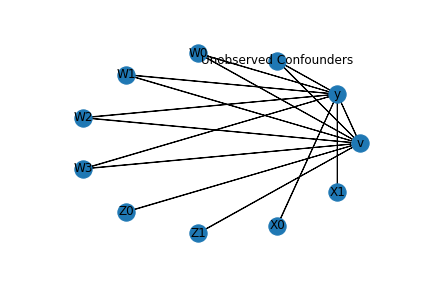

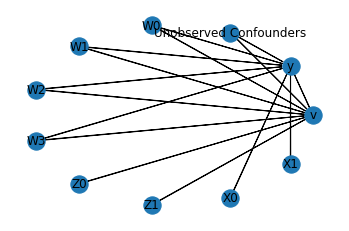

In [5]:
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [6]:
identified_estimand= model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['W0', 'W2', 'Unobserved Confounders', 'W3', 'W1']


WARN: Do you want to continue by ignoring these unobserved confounders? [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['Z1', 'Z0']


Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
d                             
──(Expectation(y|W0,W2,W3,W1))
dv                            
Estimand assumption 1, Unconfoundedness: If U→v and U→y then P(y|v,W0,W2,W3,W1,U) = P(y|v,W0,W2,W3,W1)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, Z1)/Derivative(v, Z1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→Z1,Z0)
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→v, then ¬(Z1,Z0→y)



In [13]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DMLCateEstimator",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = lambda df: df["X0"]>1, 
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v+W0+W2+W3+W1


*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
d                             
──(Expectation(y|W0,W2,W3,W1))
dv                            
Estimand assumption 1, Unconfoundedness: If U→v and U→y then P(y|v,W0,W2,W3,W1,U) = P(y|v,W0,W2,W3,W1)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, Z1)/Derivative(v, Z1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→Z1,Z0)
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→v, then ¬(Z1,Z0→y)

## Realized estimand
b: y~v+W0+W2+W3+W1
## Estimate
Value: 7.257043672350611



In [8]:
print("True causal estimate is", data["ate"])

True causal estimate is 6.608269126871875


### CATE Object and Confidence Intervals

In [9]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DMLCateEstimator",
                                     target_units = lambda df: df["X0"]>1, 
                                     confidence_intervals=True,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{
                                                               'inference': 'bootstrap',
                                                            }
                                              })
print(dml_estimate)
print(dml_estimate.cate_estimates[:10])
print(dml_estimate.effect_intervals[:10])

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v+W0+W2+W3+W1
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   16.8s


KeyboardInterrupt: 

# Works with any EconML method

In [ ]:
## Continuous treatment, Continuous outcome

In [ ]:
from sklearn.linear_model import LogisticRegression
orthoforest_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.ortho_forest.ContinuousTreatmentOrthoForest",
                                 target_units = lambda df: df["X0"]>1, 
                                 confidence_intervals=False,
                                method_params={"init_params":{
                                                    'n_trees':2, 
                                                    },
                                               "fit_params":{}
                                              })
print(orthoforest_estimate)

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
#todo needs binary y
drlearner_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.drlearner.LinearDRLearner",
                                 target_units = lambda df: df["X0"]>1, 
                                 confidence_intervals=False,
                                method_params={"init_params":{
                                                    'model_propensity': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto')
                                                    },
                                               "fit_params":{}
                                              })
print(drlearner_estimate)

## Instrumental Variable Method

In [ ]:
 import keras
from econml.deepiv import DeepIVEstimator
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(2,)),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])                
response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(2,)),
                                    keras.layers.Dropout(0.17), 
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(1)])

deepiv_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="iv.econml.deepiv.DeepIVEstimator",
                                        target_units = lambda df: df["X0"]>1, 
                                        confidence_intervals=False,
                                method_params={"init_params":{'n_components': 10, # Number of gaussians in the mixture density networks
                                                              'm': lambda z, x: treatment_model(keras.layers.concatenate([z, x])), # Treatment model,
                                                              "h": lambda t, x: response_model(keras.layers.concatenate([t, x])), # Response model
                                                              'n_samples': 1, # Number of samples used to estimate the response
                                                              'first_stage_options': {'epochs':25},
                                                              'second_stage_options': {'epochs':25}
                                                             },
                                               "fit_params":{}})
print(deepiv_estimate)

### Linear Model 

In [ ]:
linear_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")
print(linear_estimate)

## Refuting the estimate

### Random 

In [ ]:
res_random=model.refute_estimate(identified_estimand, econml_estimate, method_name="random_common_cause")
print(res_random)

### Adding an unobserved common cause variable

In [ ]:
res_unobserved=model.refute_estimate(identified_estimand, econml_estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="binary_flip", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

#### Replacing treatment with a random (placebo) variable

In [ ]:
res_placebo=model.refute_estimate(identified_estimand, econml_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

#### Removing a random subset of the data

In [ ]:
res_subset=model.refute_estimate(identified_estimand, econml_estimate,
        method_name="data_subset_refuter", subset_fraction=0.8)
print(res_subset)